1. Read in all of the predicted (major topic) congress speech data (from multiple files. keep just party, cong_number, text, date, topic)
2. Keep only rows where party == democrat or republican 
3. Partition the data by major topic. 
4. Chunk into 2.5k character length rows
5. Tokenize:
	a. Remove Roberts Rules tokens
	b. Keep only tokens in the news data
	c. Only tokens that appear in 10 documents or more
6. Within each topic, predict party. Use Elastic Net. 
7. This will give you 21 models --- one for each topic
8. Output classification success of each.
9. Output top 20 Republican and Democrat words for each model.


### Update

1. May be the first thing to do with the news bigram/trigram data is to only keep bigrams/trigrams that appear in at least 100 articles.

### Update

When we are subetting the news data, we should limit bigrams that appear in 100 or more documents (for now) and trigrams that appear in 10 or more documents (for now). I think that is a good catch.

In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.externals import joblib

In [2]:
import nltk
from nltk import word_tokenize          
from nltk.stem.porter import PorterStemmer
import re
import string

stemmer = PorterStemmer()
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

#def tokenize(text):
#    tokens = nltk.word_tokenize(text)
#    stems = stem_tokens(tokens, stemmer)
#    return stems

def tokenize(text):
    text = "".join([ch for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

%matplotlib inline
import matplotlib.pyplot as plt
from pandas_confusion import ConfusionMatrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.cross_validation import train_test_split

with open('../roberts_rules/all_text.txt', 'rt') as f:
    text = f.read()
text = text.decode('ascii', 'ignore')
text = re.sub(r'\d+', '', text)

vect = CountVectorizer(tokenizer=tokenize, stop_words='english', ngram_range=(2, 3)) 
vect.fit([text])
roberts_rules = set(vect.get_feature_names())

def most_informative_feature_for_class(vectorizer, classifier, classlabel, n=10):
    labelid = list(classifier.classes_).index(classlabel)
    feature_names = vectorizer.get_feature_names()
    topn = sorted(zip(classifier.coef_[labelid], feature_names))[-n:]

    for coef, feat in topn:
        print classlabel, feat, coef

def most_informative_feature_for_class_svm(vectorizer, classifier,  n=10):
    labelid = 3 # this is the coef we're interested in. 
    feature_names = vectorizer.get_feature_names()
    svm_coef = classifier.coef_.toarray() 
    topn = sorted(zip(svm_coef[labelid], feature_names))[-n:]

    for coef, feat in topn:
        print feat, coef

def print_top10(vectorizer, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[-10:]
        print("%s: %s" % (class_label,
              " | ".join(feature_names[j] for j in top10)))

def get_top_features(vectorizer, clf, class_labels, n=20):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    top_features = {}
    for i, class_label in enumerate(class_labels):
        topN = np.argsort(clf.coef_[i])[-n:]
        top_features[class_label] = [feature_names[j] for j in topN][::-1]
    return top_features

def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print "\t%.4f\t%-20s\t\t%.4f\t%-20s" % (coef_1, fn_1, coef_2, fn_2)

## Read Predicted Congress dataset

In [3]:
adf = None
for nth in range(107, 113):
    print nth
    df = pd.read_csv('../data/congress_%d_predict_major_label.csv' % nth) #, nrows=10)
    if adf is None:
        adf = df
    else:
        adf = pd.concat([adf, df])
adf

107
108
109
110
111
112


,date,text,party,topic,cong_number
0,2002-03-19,mr speaker yield minut gentleman virginia mr m...,100,20,107
1,2002-11-19,mr speaker would like submit appropri congress...,100,21,107
2,2002-06-06,mr speaker yesterday flight lo angel delay dep...,100,1,107
3,2002-03-06,mr speaker earlier today unabl cast vote two r...,100,3,107
4,2002-04-16,mr speaker thank gentleman yield time mr speak...,100,20,107
5,2002-10-01,mr speaker yield minut gentlewoman new york ms...,100,15,107
6,2001-10-16,mr speaker friday octob unavoid miss two roll ...,100,7,107
7,2002-05-09,mr chairman although disappoint rule bodi rise...,100,16,107
8,2002-10-01,mr speaker yield minut gentlewoman texa ms edd...,100,19,107
9,2002-10-01,mr speaker yield minut gentleman new jersey mr...,100,20,107


In [4]:
df = df[df.party.isin([100, 200])]

## Split long bill to smaller chunk (2500 chars)

In [5]:
import re
import textwrap

def insert_chars_split_marker(text, cc=2500):
    # FIXME: text still has number
    text = re.sub('\d+', '', text)
    out = '|'.join(textwrap.wrap(text, cc))
    return out

def insert_words_split_marker(text, wc=500):
    text = re.sub('\d+', '', text)
    words = text.split()
    out = ''
    for i, w in enumerate(words):
        if i != 0 and i % wc == 0:
            out += '|' + w
        else:
            out += ' ' + w
    return out

In [6]:
def remove_roberts_rules(all_vocab):
    vocab = []
    i = 0
    for a in all_vocab:
        if a not in roberts_rules:
            vocab.append(a)
        else:
            #print a
            i += 1
    print("Removed {0:d}".format(i))
    print("Total {0:d}".format(len(vocab)))
    return vocab


In [7]:
def get_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top_a = coefs_with_fns[:n]
    top_b = coefs_with_fns[:-(n + 1):-1]
    return top_a, top_b

1 3310


/opt/venv/local/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


1 4786
14160
Removed 399
Total 13761
13761
9208
11147
Results for Elastic Net
Training time: 0.435223s; Prediction time: 0.000519s
             precision    recall  f1-score   support

        100       0.88      0.75      0.81       410
        200       0.83      0.93      0.88       548

avg / total       0.85      0.85      0.85       958

100 higher tax 2.50490940529
100 incom tax 2.52924186711
100 tax hike 2.63857971206
100 feder govern 2.79364078553
100 debt crisi 2.82214076944
100 presid obama 2.9417366511
100 american peopl 3.08882846312
100 speaker ask unanim 3.1618336688
100 rais tax 4.0821317686
100 tax increas 4.1600317448
	-6.2409	middl class         		4.1600	tax increas         
	-5.0191	deficit reduct      		4.0821	rais tax            
	-4.6259	tax cut             		3.1618	speaker ask unanim  
	-4.3934	tax break           		3.0888	american peopl      
	-3.7897	republican colleagu 		2.9417	presid obama        
	-3.4727	republican leader   		2.8221	debt crisi          
	-

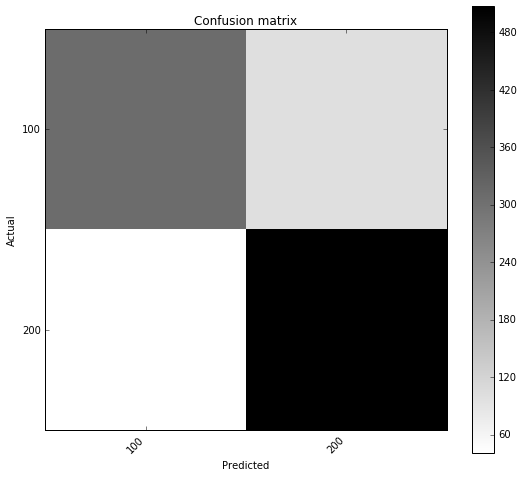

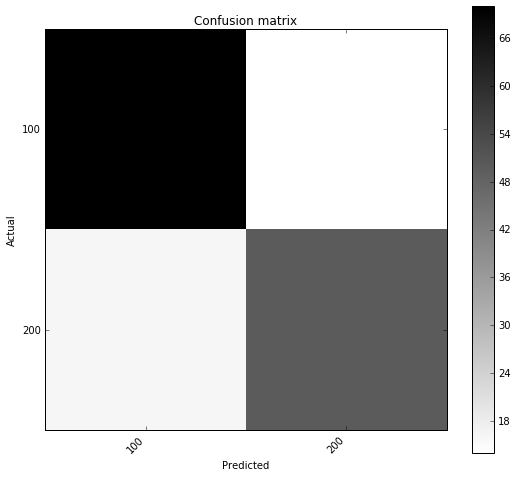

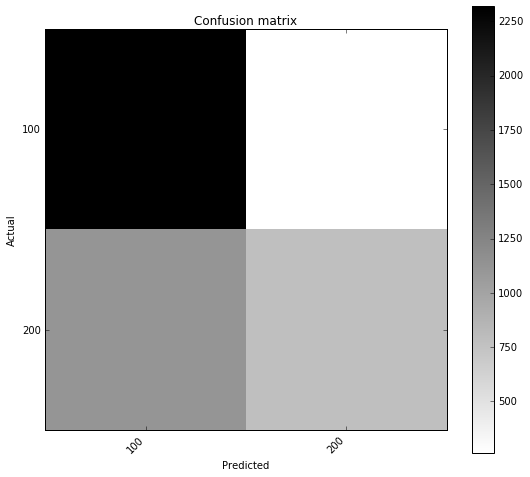

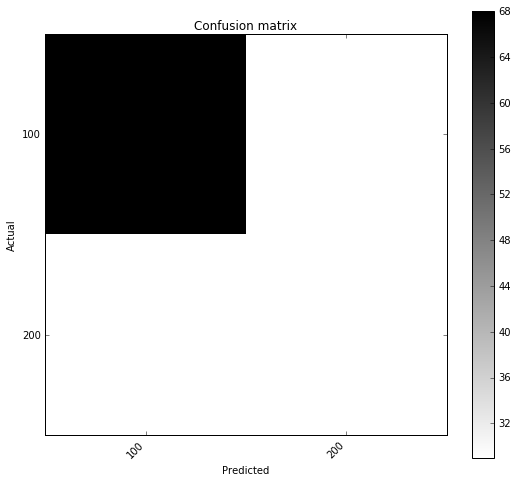

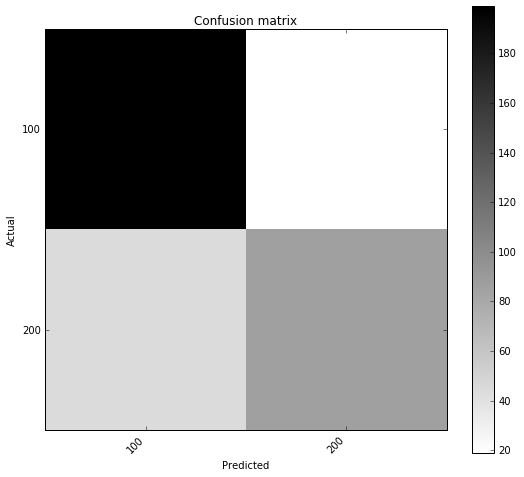

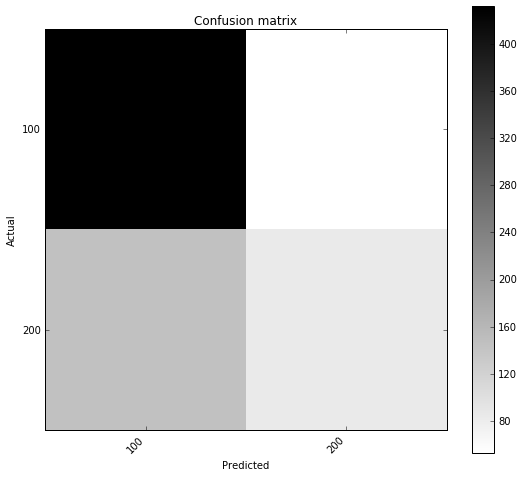

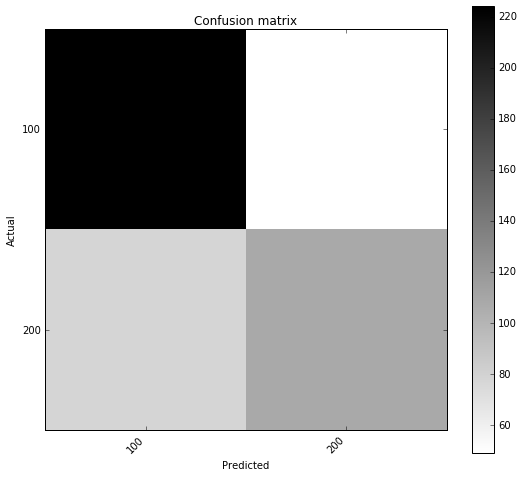

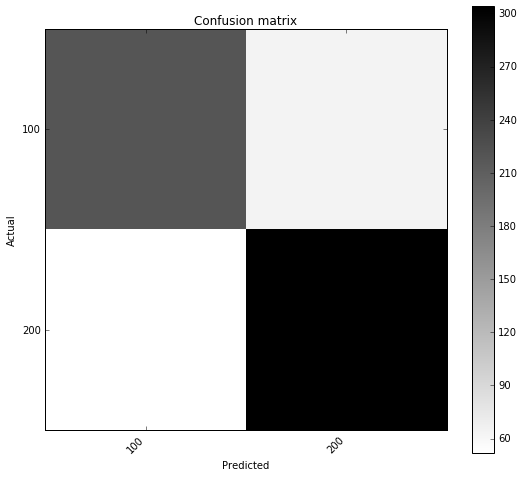

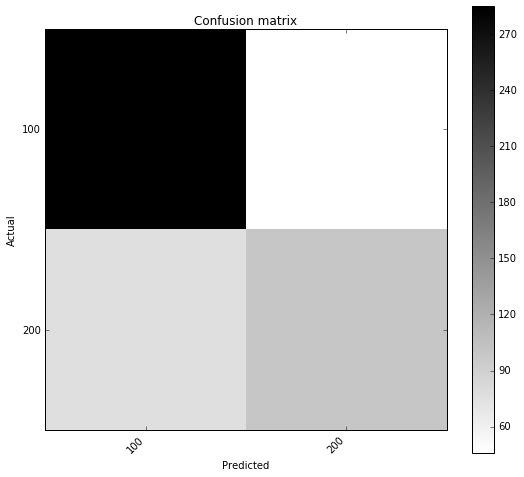

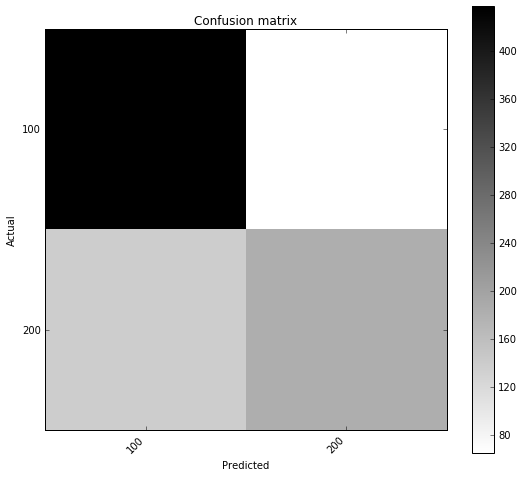

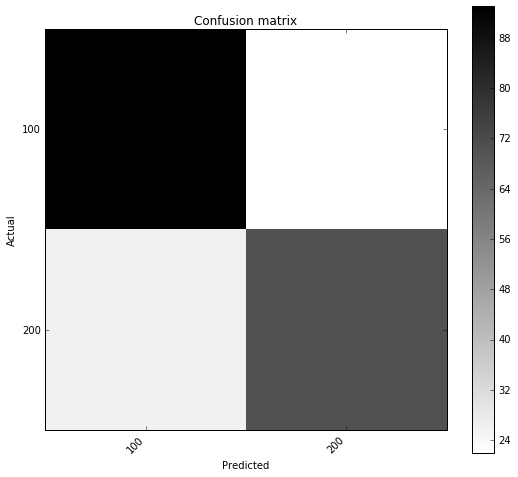

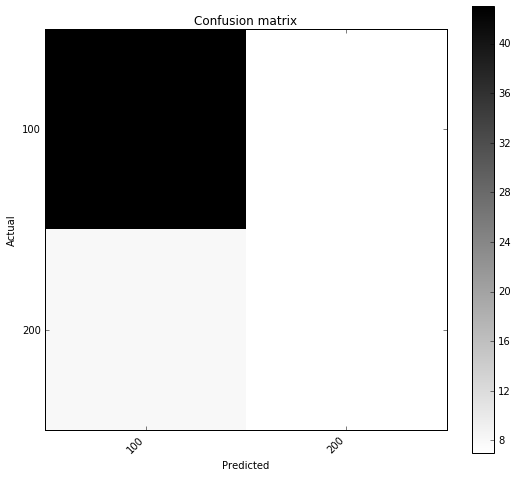

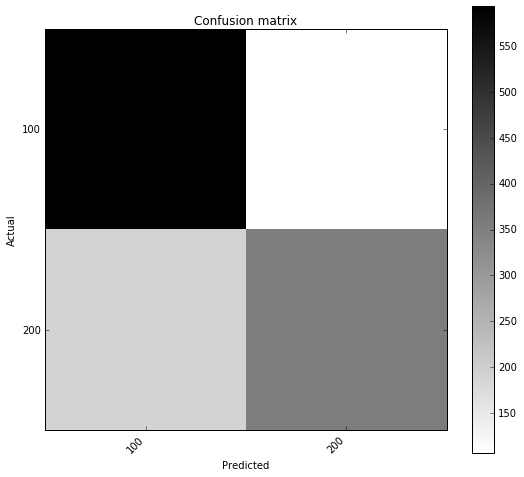

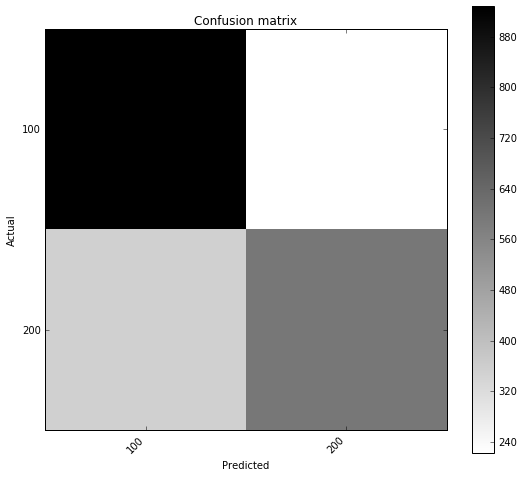

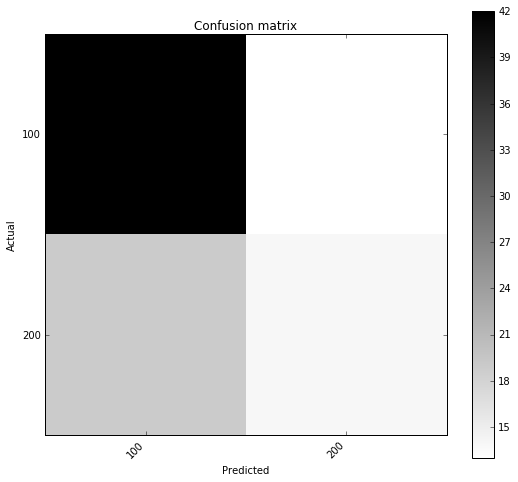

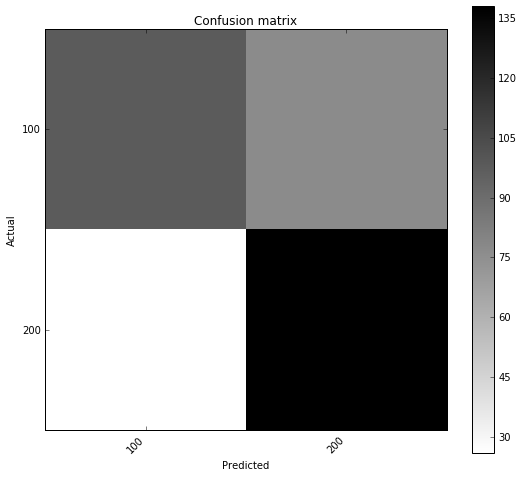

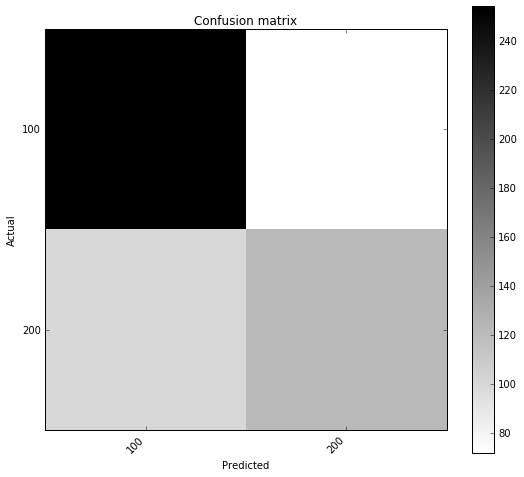

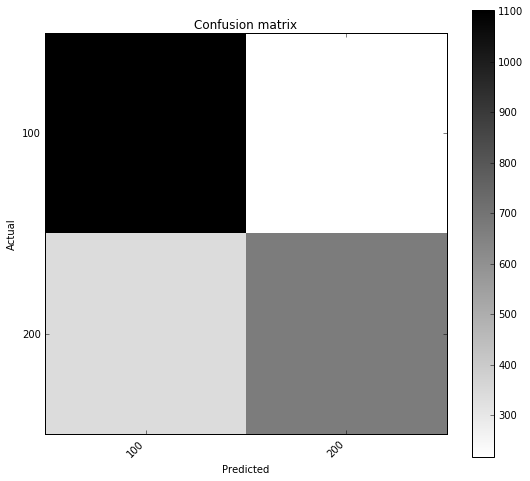

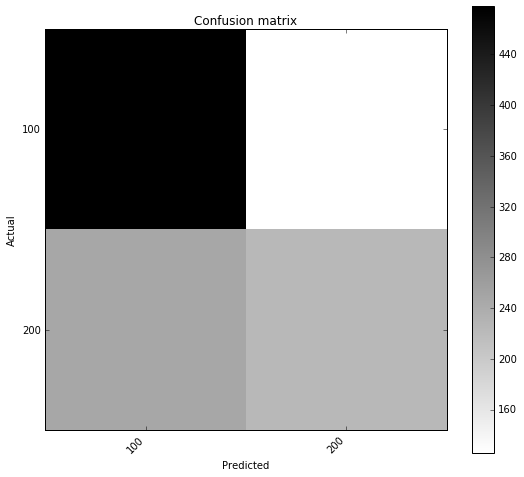

In [8]:
stats = []
for t in [1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]: #df.topic.unique():
    st = []
    sdf = df[df.topic == t]
    print t, len(sdf)
    st.append(t)
    st.append(len(sdf))

    if True:
        # split long text to multiple rows
        sdf.loc[:, 'text'] = sdf.text.astype(str).apply(lambda c: insert_chars_split_marker(c, 2500))
        s = sdf['text'].str.split('|', expand=True).stack()
        i = s.index.get_level_values(0)
        new_df = sdf.loc[i].copy()
        new_df['chunk'] = s.index.get_level_values(1)
        new_df['text'] = s.values
        sdf = new_df.reset_index(drop=True)
    
    print t, len(sdf)
    st.append(len(sdf))

    vect = CountVectorizer(ngram_range=(2, 3), min_df=10) 
    vect.fit(sdf.text)
    print len(vect.get_feature_names())
    st.append(len(vect.get_feature_names()))
    
    vocab = remove_roberts_rules(vect.vocabulary_)
    print len(vocab)
    st.append(len(vocab))
    
    new_vocab = []
    ng = pd.read_csv('../data/major_%s_news_2gram_df100.csv' % t)
    bigrams = set(ng.ngram.tolist())
    st.append(len(bigrams))
    for v in vocab:
        if v in bigrams:
            new_vocab.append(v)
    print len(new_vocab)
    st.append(len(new_vocab))
    ng = pd.read_csv('../data/major_%s_news_3gram_df10.csv' % t)
    trigrams = set(ng.ngram.tolist())
    st.append(len(trigrams))
    for v in vocab:
        if v in trigrams:
            new_vocab.append(v)
    print len(new_vocab)
    st.append(len(new_vocab))

    X = sdf.text
    y = sdf.party

    X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    vect = CountVectorizer(ngram_range=(2, 3), min_df=10, vocabulary=new_vocab)

    X_train = vect.transform(X_train)
    transformer = TfidfTransformer()
    X_train = transformer.fit_transform(X_train)

    X_test = vect.transform(X_test)
    transformer = TfidfTransformer()
    X_test = transformer.fit_transform(X_test)

    from sklearn.linear_model import SGDClassifier

    elastic_clf = SGDClassifier(loss='log', alpha=.0001, n_iter=100, penalty="elasticnet")
    t0 = time.time()
    elastic_clf.fit(X_train, y_train)
    t1 = time.time()
    prediction_elastic = elastic_clf.predict(X_test)
    t2 = time.time()
    time_elastic_train = t1-t0
    time_elastic_predict = t2-t1

    print("Results for Elastic Net")
    print("Training time: %fs; Prediction time: %fs" % (time_elastic_train, time_elastic_predict))
    print(classification_report(y_test, prediction_elastic))
    st.append(accuracy_score(y_test, prediction_elastic))

    most_informative_feature_for_class(vect, elastic_clf, 100)
    show_most_informative_features(vect, elastic_clf, 20)
    
    top_a, top_b = get_most_informative_features(vect, elastic_clf, 20)
    top_a_df = pd.DataFrame(top_a)
    top_a_df.columns = ['coef', 'term']
    top_b_df = pd.DataFrame(top_b)
    top_b_df.columns = ['coef', 'term']
    top_a_df.to_csv('../new_data/major_%s_top20_rep.csv' % t, index=False)
    top_b_df.to_csv('../new_data/major_%s_top20_dem.csv' % t, index=False)

    joblib.dump(vect, "../new_models/major_%s_vec_count_cong_23gram.joblib" % t)
    joblib.dump(elastic_clf, "../new_models/major_%s_cong_clf_elastic.joblib" % t)

    y_test_df = pd.DataFrame(y_test).reset_index(drop=True)
    y_test_df['predicted'] = prediction_elastic
    y_test_df.to_csv('../new_data/major_%s_test_prediction_party.csv' % t, index=False)

    y_true = y_test.reset_index(drop=True)
    confusion_matrix = ConfusionMatrix(y_true, prediction_elastic)
    print("Confusion matrix:\n%s" % confusion_matrix)

    confusion_matrix.plot()

    from sklearn.metrics import confusion_matrix
    conf = confusion_matrix(y_true, prediction_elastic)
    conf_df = pd.DataFrame(conf)
    conf_df.columns = elastic_clf.classes_
    conf_df.index = elastic_clf.classes_
    conf_df.to_csv('../new_data/major_%s_test_confusion_matrix_party.csv' % t, index_label="actual \ predicted")
    print conf_df

    stats.append(st)

In [9]:
stats_df = pd.DataFrame(stats)
stats_df.columns = ['topic', 'rows', 'rows (splitted)', 'all bi/trigrams', 'remove roberts rules', 'total news bigrams', 'found in news bigrams', 'total news trigrams', 'found in news bi/trigrams', 'score']
stats_df

,topic,rows,rows (splitted),all bi/trigrams,remove roberts rules,total news bigrams,found in news bigrams,total news trigrams,found in news bi/trigrams,score
0,1,3310,4786,14160,13761,62891,9208,506193,11147,0.851775
1,2,607,748,616,577,11081,292,77029,335,0.800000
2,3,21192,22409,19244,18672,282883,12344,1725306,14459,0.691209
3,4,598,774,927,883,1234,165,19094,192,0.625806
4,5,1326,1745,2421,2324,34781,1694,248656,1901,0.816619
5,6,3038,3571,5832,5711,70877,3468,497868,3917,0.723077
6,7,1923,2292,3063,2956,14595,1093,108464,1278,0.723312
7,8,2342,3199,7595,7412,56341,4639,356459,5496,0.818750
8,10,2030,2533,3700,3550,94708,2066,583086,2316,0.759369
9,12,3333,4116,7047,6792,275912,4003,1653778,4643,0.753641
